# 2.Quora Insincere Questions Classification (Preprocessing)

In [1]:
import string
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
%matplotlib inline
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [5]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [6]:
# Parameters and definitions
RANDOM_SEED = 0
VAL_SET_SIZE = 0.2

In [7]:
np.random.seed(RANDOM_SEED)

### File Paths

In [8]:
DATA_DIR = "../input/"
TRAIN_SAMPLES = DATA_DIR+"Qtrain.csv"
TEST_SAMPLES = DATA_DIR+"Qtest.csv"
EMBD_SAMPLES = DATA_DIR+"Qembeddings.zip"
SUBMISSION_FILE = DATA_DIR+"Qsubmission.csv"

###   2.1 Utility Functions

In [9]:
#loads the training and testing sets into the memory.
def load_data():
    return pd.read_csv(TRAIN_SAMPLES), pd.read_csv(TEST_SAMPLES)

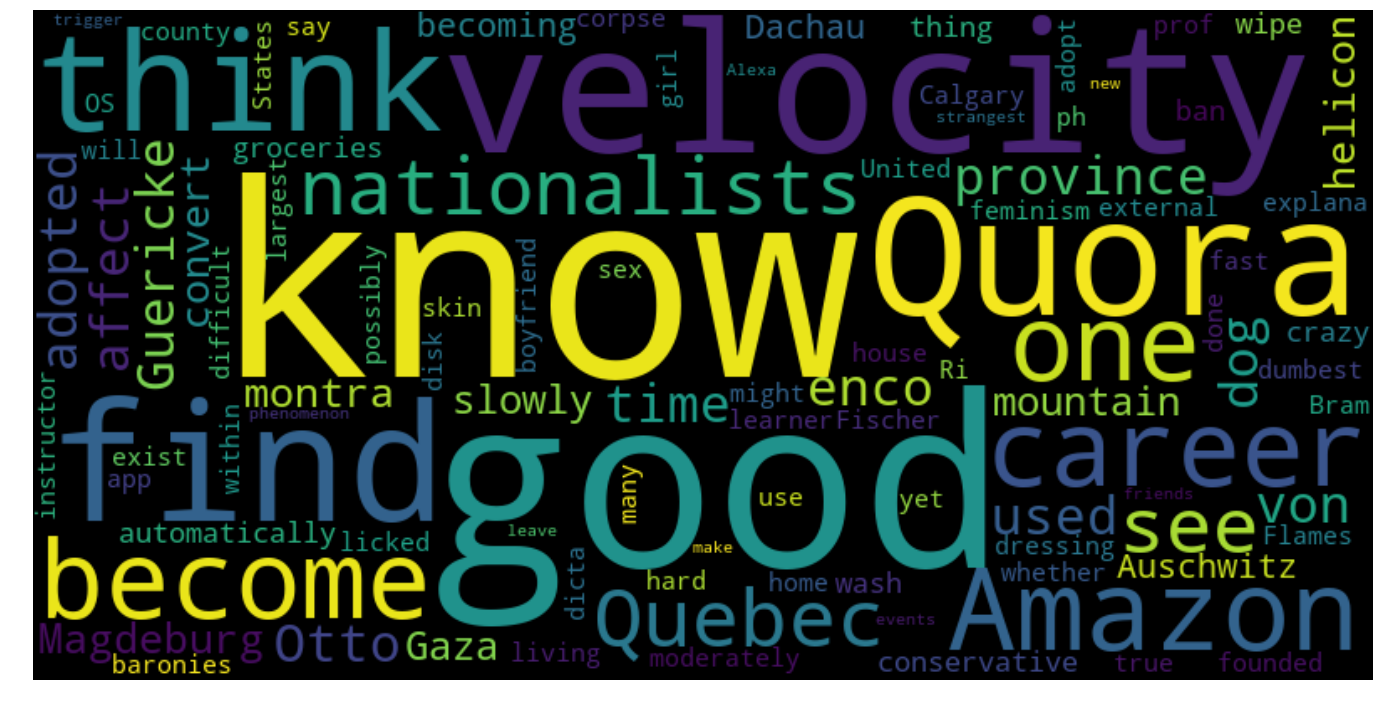

In [20]:
# Word Cloud (most frequently used words)
wc = WordCloud(random_state=0, max_words=100, width=800, height=400).generate(str(df_train["question_text"]))
plt.figure(figsize=(24,16))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("2_wc.pdf", bbox_inches="tight")
plt.show()

###  2.2 Feature Engineering

In [21]:
def build_features(data):
    """"""
    # Number of words on the data set
    data["n_words"] = data["question_text"].apply(lambda x: len(str(x).split()))
    
    # Number of unique words on the data set
    data["uniq_words"] = data["question_text"].apply(lambda x: len(set(str(x).split())))
    
    # Number of characters on data set
    data["n_chars"] = data["question_text"].apply(lambda x: len(str(x)))

    # Number of punctuations on data set
    data["n_punct"] = data['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

    # Number of title case words on data set
    data["n_up_words"] = data["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    # Number of title case words on data set
    data["n_titles"] = data["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    # Average length of the words on data set
    data["m_w_len"] = data["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return data

In [22]:
df_train = build_features(df_train)

In [23]:
# Record the min, max and average value for the new columns (n_words	uniq_words	n_chars	n_punct	n_up_words	n_titles	m_w_len)
df_train.describe()

,target,n_words,uniq_words,n_chars,n_punct,n_up_words,n_titles,m_w_len
count,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06,1.306122e+06
mean,6.187018e-02,1.280361e+01,1.213578e+01,7.067884e+01,1.746492e+00,4.506570e-01,2.121108e+00,4.671008e+00
std,2.409197e-01,7.052437e+00,6.040779e+00,3.878428e+01,1.672051e+00,8.490158e-01,1.495405e+00,8.187338e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,8.000000e+00,8.000000e+00,4.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,4.111111e+00
50%,0.000000e+00,1.100000e+01,1.100000e+01,6.000000e+01,1.000000e+00,0.000000e+00,2.000000e+00,4.600000e+00
75%,0.000000e+00,1.500000e+01,1.500000e+01,8.500000e+01,2.000000e+00,1.000000e+00,3.000000e+00,5.142857e+00
max,1.000000e+00,1.340000e+02,9.600000e+01,1.017000e+03,4.110000e+02,3.700000e+01,3.700000e+01,5.766667e+01


In [24]:
# Sneak peak into the updated training set
df_train.head()

,qid,question_text,target,n_words,uniq_words,n_chars,n_punct,n_up_words,n_titles,m_w_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,1,2,3,4.200000


### 2.3 Data Preprocessing

In [25]:
# Five questions do not have sufficient information to let the model learn. To decide if we should keep them we will examine, using a
# correlation matrix, how these samples affect the correlation scores. 
for key, value in df_train.iterrows():
    if value["n_chars"] < 5:
        print("Question: {}, Number of Characters: {}, Target: {}".format(value["question_text"], 
                                                                          value["n_chars"], 
                                                                          value["target"]))

Question: Is , Number of Characters: 3, Target: 1
Question: If , Number of Characters: 3, Target: 1
Question: ", Number of Characters: 1, Target: 1
Question: Do , Number of Characters: 3, Target: 1
Question: W, Number of Characters: 1, Target: 1


#### Outcome:
* Removing these samples from the dataset does not affect
* the correlation score between n_chars and target attributes so we will remove them from now since they do not contribute on the overall mprovement in model results.

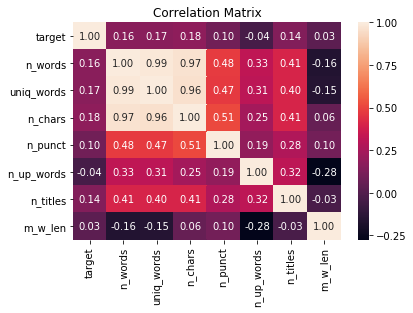

In [26]:
# Correlation Matrix: 
ax = plt.axes()
corr = df_train.corr()
ax.set_title("Correlation Matrix")
sns.heatmap(corr,
            fmt=".2f",
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax);
plt.savefig("3_corr_mat.pdf", bbox_inches="tight")

#### Observation:
* No obvious correlations with target. Many weak correlations with the biggest being n_chars (number of characters) -> 0.18.
*  Other expected correlations are: unique words - number of words, number of words - number of characters.

In [27]:
# We will remove those entries and keep only the questions of length 5 or more
# New dataset info appear below.
df_train = df_train[df_train["n_chars"]>=5]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306117 entries, 0 to 1306121
Data columns (total 10 columns):
qid              1306117 non-null object
question_text    1306117 non-null object
target           1306117 non-null int64
n_words          1306117 non-null int64
uniq_words       1306117 non-null int64
n_chars          1306117 non-null int64
n_punct          1306117 non-null int64
n_up_words       1306117 non-null int64
n_titles         1306117 non-null int64
m_w_len          1306117 non-null float64
dtypes: float64(1), int64(7), object(2)
memory usage: 109.6+ MB


In [28]:
def preprocess(data):
    # Convert data set to lowercase
    data["question_text"] = data["question_text"].apply(lambda s: s.lower())
    
    # Remove punctuation from the data set
    data["question_text"] = data['question_text'].str.replace('[^\w\s]','')

    # Remove digits from the data set
    data["question_text"] = data["question_text"].str.replace('\d+', '')

    # Remove stop words from question text
    data["question_text"] = data["question_text"].apply(lambda s: " ".join([item for item in s.split() if item not in stop_words]))

    # Stem words
    data["question_text"] = data["question_text"].apply(lambda s: " ".join([stemmer.stem(w) for w in s.split()]))
    
    return data

In [29]:
df_train = preprocess(df_train)
df_train.head()

,qid,question_text,target,n_words,uniq_words,n_chars,n_punct,n_up_words,n_titles,m_w_len
0,00002165364db923c7e6,quebec nationalist see provinc nation,0,13,13,72,1,0,2,4.615385
1,000032939017120e6e44,adopt dog would encourag peopl adopt shop,0,16,15,81,2,0,1,4.125000
2,0000412ca6e4628ce2cf,veloc affect time veloc affect space geometri,0,10,8,67,2,0,2,5.800000
3,000042bf85aa498cd78e,otto von guerick use magdeburg hemispher,0,9,9,57,1,0,4,5.444444
4,0000455dfa3e01eae3af,convert montra helicon mountain bike chang tyre,0,15,15,77,1,2,3,4.200000


In [30]:
# Update combinatorial features
df_train = build_features(df_train)

# Delete not needed columns
del df_train["n_punct"]
del df_train["n_up_words"]
del df_train["n_titles"]

# Display the resulting DataFrame
df_train.head()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,qid,question_text,target,n_words,uniq_words,n_chars,m_w_len
0,00002165364db923c7e6,quebec nationalist see provinc nation,0,5,5,37,6.600000
1,000032939017120e6e44,adopt dog would encourag peopl adopt shop,0,7,6,41,5.000000
2,0000412ca6e4628ce2cf,veloc affect time veloc affect space geometri,0,7,5,45,5.571429
3,000042bf85aa498cd78e,otto von guerick use magdeburg hemispher,0,6,6,40,5.833333
4,0000455dfa3e01eae3af,convert montra helicon mountain bike chang tyre,0,7,7,47,5.857143


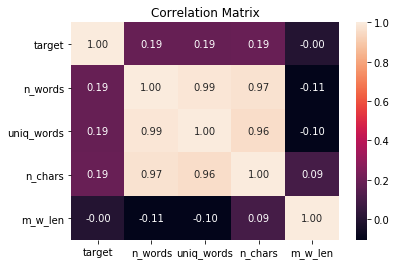

In [31]:
# Produce correlation matrix again to check if something has changed.
ax = plt.axes()
corr = df_train.corr()
ax.set_title("Correlation Matrix")
sns.heatmap(corr,
            fmt=".2f",
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax);
plt.savefig("4_corr_mat.pdf", bbox_inches="tight")

### In this challenge, we have to train a model which is able to detect if a given question in insincere or not. The model should be able if the question is a statement rather than a question that if answered will provide benefit to Quora's online community. We will implement and compare various model  in the next few notebooks and finally pick the highest performing one .

